# Machine Learning 2023-2024 - UMONS

# Linear Regression

**In this lab about linear regression, we'll be working with the library [statsmodels](https://www.statsmodels.org/stable/index.html), which provides numerous classes and functions for the estimation of statistical models.**

**The dataset that we'll be considering is [Diamonds](https://www.kaggle.com/datasets/shivam2503/diamonds), which contains several characteristics of a series of diamonds, such as their dimensions, the quality of their cuts, their prices, etc... The goal of the lab will be to define linear regression models to best estimate diamonds prices using a bunch of predictor variables, and to understand the meaning of the obtained coefficients.**

**Dataset's column information:**

- 'price': price in US dollars.
- 'carat': weight of the diamond. 
- 'cut': quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- 'color': diamond's color's, from J (worst) to D (best).
- 'clarity': how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- 'x': length in mm.
- 'y': width in mm. 
- 'z': height in mm.
- 'table': width of top of the diamond relative to its widest point. 
- 'depth' = 2z/(x+y) 

**Import the necessary libraries**

In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn import datasets

**We load the 'Diamond' dataset as a Dataframe. We also add two columns with noise in order to experiment with variable selection.**

In [2]:
df = pd.read_csv('data/diamonds.csv', index_col=0)
# Add a column with noise
df['noise'] = np.random.normal(0, 1, len(df))
df['x_noise'] = df['x'] + np.random.normal(0, 1, len(df))
df

,carat,cut,color,clarity,depth,table,price,x,y,z,noise,x_noise
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,0.424000,5.484551
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,-0.155725,4.204391
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,1.160164,3.626158
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,-0.720282,4.264982
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,-0.184020,3.921647
...,...,...,...,...,...,...,...,...,...,...,...,...
53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50,0.390308,4.732556
53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61,-0.870187,6.084400
53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56,-1.341619,6.642254
53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74,-1.383794,7.899491


**1) Check the number of observations, the number of columns, the column types, and the number of missing values per columns.**

In [3]:
print(df.shape)
print(df.dtypes)
print(df.isna().sum())

(53940, 12)
carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
noise      float64
x_noise    float64
dtype: object
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
noise      0
x_noise    0
dtype: int64


## Data cleaning

**2) Set the data type of the categorical variables to 'category'.**

In [4]:
df = df.astype({'cut': 'category', 'color': 'category', 'clarity': 'category'})

**3) Make a scatter plot of the variable 'price' along the y-axis and the variable 'x' along the x-axis. Do the same for the variables 'y' and 'z'.**

**Do you notice anything special?**

<Axes: xlabel='x', ylabel='price'>

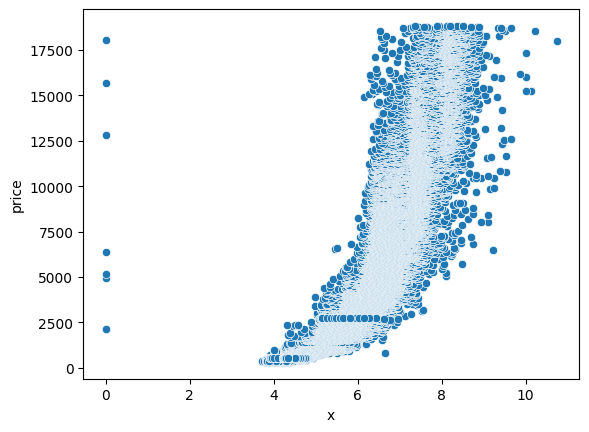

In [5]:
sns.scatterplot(data=df, x='x', y='price')

<Axes: xlabel='y', ylabel='price'>

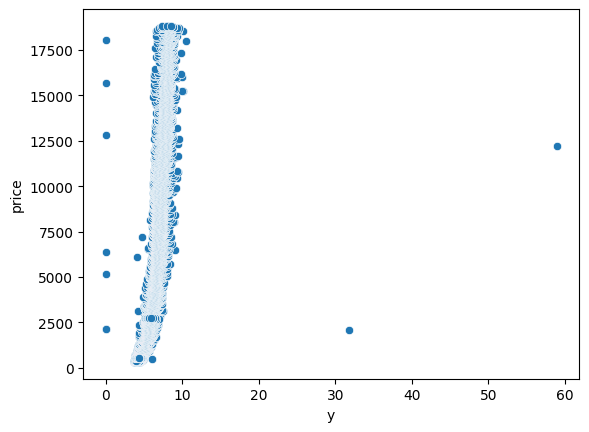

In [6]:
sns.scatterplot(data=df, x='y', y='price')

<Axes: xlabel='z', ylabel='price'>

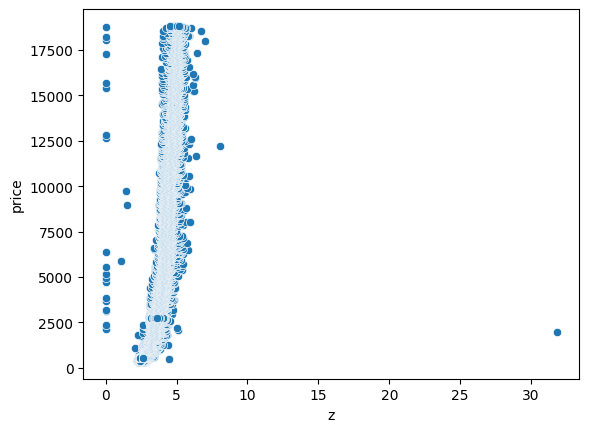

In [7]:
sns.scatterplot(data=df, x='z', y='price')

Some observations of 'x', 'y' and 'z' take on the values 0. Considering that these variables represent dimensions, such values are impossible and likely result from an encoding mistake. Moreover, for 'y' and 'z', we observe some values greater than 30mm, which are far off from the rest of the distribution. These observations are called outliers. 

**4) Following your observations from the previous question, what would you do?**

In [8]:
# Remove outliers
for col in ['x', 'y', 'z']:
  df = df[(df[col] != 0) & (df[col] < 30)]

<Axes: xlabel='x', ylabel='price'>

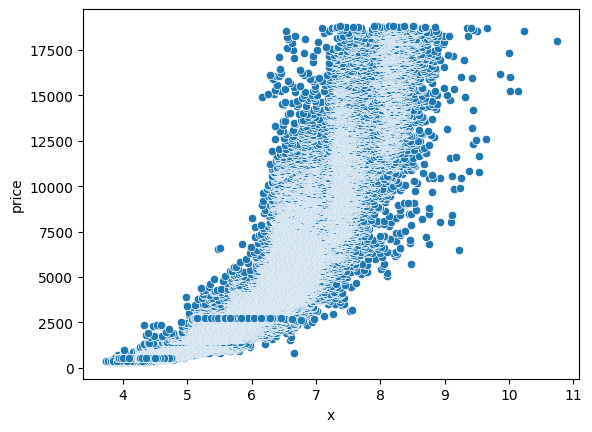

In [9]:
sns.scatterplot(data=df, x='x', y='price')

<Axes: xlabel='y', ylabel='price'>

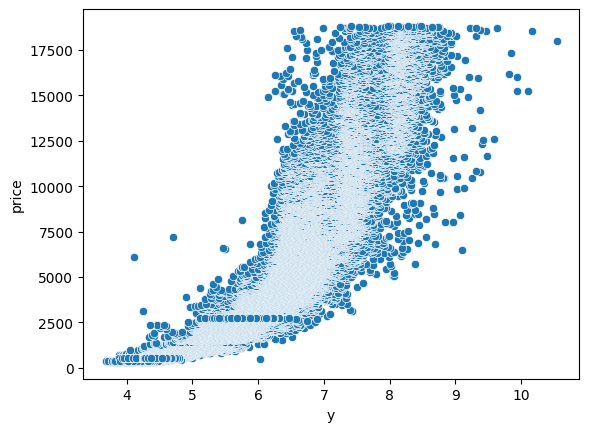

In [10]:
sns.scatterplot(data=df, x='y', y='price')

<Axes: xlabel='z', ylabel='price'>

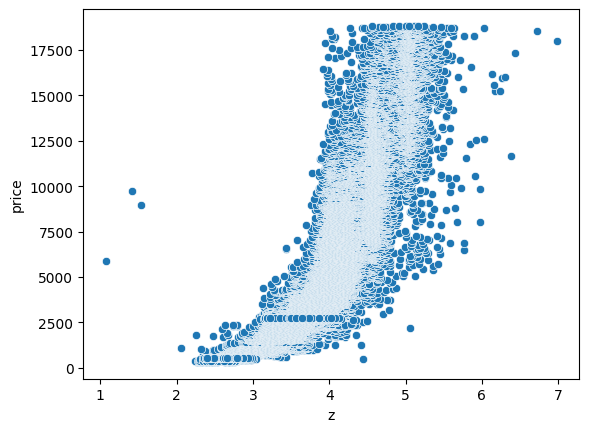

In [11]:
sns.scatterplot(data=df, x='z', y='price')

## Linear regression using statsmodels

**5) Using the [`dmatrices`](https://patsy.readthedocs.io/en/latest/API-reference.html#patsy.dmatrices) function of the patsy library and the [`OLS`](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html) class of the statsmodels library, fit a linear regression model to the diamonds' price using the variable 'x' as your predictor. Then, based on the results given by the [`summary`](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.summary.html) method:** 

- **5.1) Report the coefficient of determination and the adjusted coefficient of determination of the model.**
- **5.2) How would you write the linear regression model?**
- **5.3) Are the fitted coefficients statistically significant at the 5% significance level?**
- **5.4) How would you obtain the confidence intervals?**
- **5.5) How do you interpret the model?**

In [12]:
y, X = dmatrices('price ~ x', data=df, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                 1.994e+05
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:32:09   Log-Likelihood:            -4.8181e+05
No. Observations:               53917   AIC:                         9.636e+05
Df Residuals:                   53915   BIC:                         9.636e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.418e+04     41.329   -343.149      0.000   -1.43e+04   -1.41e+04
x           3160.2067      7.077    446.541      0.000    3146.336    3174.078
==============================================================================
Omnibus:                    12155.805   Durbin-Watson:                   0.415
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34564.825
Skew:                           1.190   Prob(JB):                         0.00
Kurtosis:                       6.118   Cond. No.                         31.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

5.1) $R^2 \approx \bar{R}^2 = 0.787$.\
5.2) The (simple) linear regression model writes $\hat{y} = \beta_0 + \beta_1x = -1.418e^{04} + 3160.21 x$, where $\hat{y}$ is the predicted diamond price.\
5.3) The p-values associated to $\beta_0$ and $\beta_1$ are lower than 0.05, so both coefficients are statistically significant.\
5.4) The CI for $\beta_0$ is $[-1.43e^{4}, -1.41e^{4}]$, and the CI for $\beta_1$ is $[3146.34, 3174.08]$.\
5.5) A unit increase in the variable 'x' increases the average diamond price by 3160.21 US dollars.

**6) Compute the linear regression coefficients and intercept using the formula $\hat{\beta} = (X^T X)^{-1} X^T y$. Check that the obtained coeffients are the same than in the previous exercise.**

In [13]:
beta = (np.linalg.inv(X.T @ X) @ X.T) @ y
beta

,price
0,-14182.147099
1,3160.206748


**7) Fit the diamonds' price to the variable 'cut'. Note that 'cut' is a categorical variable, which we learned to preprocess in previous labs. When calling `dmatrices`, categorical variables will automatically be converted into dummy variables. You can also use the syntax [`C(variable)`](https://patsy.readthedocs.io/en/latest/categorical-coding.html) for more flexibility.**
- **7.1) Does the model appear to be a better fit than with the variable 'x'?**
- **7.2) How would you write the linear regression model now?**
- **7.3) Are all coefficients statistically significant at the 5% significance level?**
- **7.4) How do you interpret the model ? Does the intercept have a meaning?**
- **7.5) Using `sns.boxenplot`, compare the distributions of the variable 'price' for the different values of 'cut'. Is it coherent to the model results?**  

In [14]:
y, X = dmatrices('price ~ cut', data=df, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     174.5
Date:                Mon, 15 Apr 2024   Prob (F-statistic):          9.49e-149
Time:                        14:32:11   Log-Likelihood:            -5.2318e+05
No. Observations:               53917   AIC:                         1.046e+06
Df Residuals:                   53912   BIC:                         1.046e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         4357.5009     98.768     44.119      0.000    4163.915    4551.086
cut[T.Good]       -431.0974    113.829     -3.787      0.000    -654.203    -207.992
cut[T.Very Good]  -375.6703    105.140     -3.573      0.000    -581.745    -169.595
cut[T.Premium]     221.6298    104.375      2.123      0.034      17.054     426.206
cut[T.Ideal]      -900.4956    102.389     -8.795      0.000   -1101.179    -699.812
==============================================================================
Omnibus:                    15109.104   Durbin-Watson:                   0.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34452.011
Skew:                           1.615   Prob(JB):                         0.00
Kurtosis:                       5.214   Cond. No.                         14.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

7.1) $R^2$ dropped compared to the linear regression model using 'x' as predictor. This suggests that the variable 'cut' is a poorer predictor of the diamond's prices.\
7.2) $\hat{y} = 4357.5 -431.10C_G -900.50C_I + 221.63C_P -375.67C_{VG}$.\
7.3) Yes, all p-values are smaller than 0.05.\
7.4) The average price for a 'Good' cut diamond is 4357.5 - 431.10 = 3926.4 US dollars. The average price for a 'Ideal' cut diamond is 4357.5 - 900.5 = 3457 US dollars, etc... Here the intercept represents the average price for a 'Fair' cut Diamond (which is the dropped category of the variable 'cut'), i.e. the average price of a 'Fair' cut diamond is 4357.5 US dollars.\

<Axes: xlabel='cut', ylabel='price'>

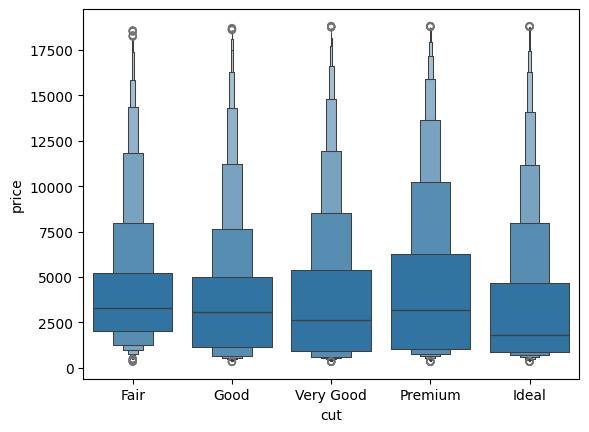

In [17]:
sns.boxenplot(data=df, y='price', x='cut')

7.5) We observe some difference between the different distributions. Notably, premium diamonds tend to be the most expensive. However, the differences are not significant enough to predict the price based on the cut accurately, which might explain why 'cut' is a poor predictor.

**8) Fit a linear regression model to the variable 'price' using 'x' and 'cut' as predictors. Based on [patsy's formulas](https://patsy.readthedocs.io/en/latest/formulas.html), add an interaction term between 'x' and 'cut'.**
- **8.1) How does the model write now?**
- **8.2) How do you interpret the model for a 'Good' cut diamond?**
- **8.3) Are all coefficients statistically significant ? If no, what does it mean?**

In [16]:
y, X = dmatrices('price ~ cut * x', data=df, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                 2.288e+04
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:49:44   Log-Likelihood:            -4.8112e+05
No. Observations:               53917   AIC:                         9.623e+05
Df Residuals:                   53907   BIC:                         9.623e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.542e+04    300.821    -51.244      0.000    -1.6e+04   -1.48e+04
cut[T.Good]         1449.6722    334.642      4.332      0.000     793.771    2105.573
cut[T.Ideal]        1168.7318    307.826      3.797      0.000     565.391    1772.073
cut[T.Premium]       546.5541    311.142      1.757      0.079     -63.286    1156.395
cut[T.Very Good]    1227.9382    313.384      3.918      0.000     613.704    1842.173
x                   3163.2553     47.577     66.487      0.000    3070.004    3256.507
cut[T.Good]:x        -99.6954     53.609     -1.860      0.063    -204.770       5.379
cut[T.Ideal]:x        50.9512     48.980      1.040      0.298     -45.051     146.953
cut[T.Premium]:x      92.3357     49.334      1.872      0.061      -4.360     189.031
cut[T.Very Good]:x     1.4355     49.894      0.029      0.977     -96.357      99.228
==============================================================================
Omnibus:                    12348.559   Durbin-Watson:                   0.439
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35242.434
Skew:                           1.207   Prob(JB):                         0.00
Kurtosis:                       6.140   Cond. No.                         589.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

8.1) $\hat{y} = -1.542e^{04} + 1449.67C_G + 1168.73C_I + 546.55C_P + 1227.94C_{VG} + 3163.25x - 99.69 x \times C_G + 50.95 x \times C_I + 92.33 x \times C_P + 1.43 x \times C_{VG}$.

8.2) For a 'Good' cut diamond, a unit increase in 'x' leads the average price of a diamond to increase by $3163.25 -99.69 = 3063.56$ US dollars. Also, the average price of a 'Good' cut diamond is $-1.542e^{04} + 1449.67 + 3163.25x -99.69x = 1.397e^{04} - 3063.56x$ Us dollars. 

8.3) The coefficients associated to all interactions terms are not statistically significant at the 0.05 significance level (given that their p-values > 0.05). For these terms, we can only say that there is not enough evidence in the data to state that their associated coefficients are significantly different from 0. However, it does not mean that they are equal to 0, we simply cannot be certain that they are.  

**9) Fit a linear regression model to the variable 'price' using all predictors.**
- **9.1) Derive the value of the Bayesian Information Criterion (BIC) and check that it corresponds to the value reported by the model's summary**  
- **9.2) Does the model appear to be a better fit than the ones using only 'x' and 'cut' as predictors? Which criterion would you look at?**
  

In [17]:
columns = list(df.columns)
columns.remove('price')
formula = 'price ~ ' + ' + '.join(columns)
print(formula)

y, X = dmatrices(formula, data=df, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

price ~ carat + cut + color + clarity + depth + table + x + y + z + noise + x_noise


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 2.499e+04
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:49:44   Log-Likelihood:            -4.5524e+05
No. Observations:               53917   AIC:                         9.105e+05
Df Residuals:                   53891   BIC:                         9.108e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -5011.3960    654.959     -7.651      0.000   -6295.120   -3727.672
cut[T.Good]        481.5199     34.000     14.163      0.000     414.881     548.159
cut[T.Ideal]       750.4468     33.627     22.317      0.000     684.537     816.356
cut[T.Premium]     718.2402     32.131     22.354      0.000     655.264     781.217
cut[T.Very Good]   617.8534     32.877     18.793      0.000     553.414     682.293
color[T.E]        -209.0315     17.797    -11.745      0.000    -243.914    -174.149
color[T.F]        -268.0051     17.999    -14.890      0.000    -303.284    -232.726
color[T.G]        -476.4204     17.624    -27.033      0.000    -510.964    -441.877
color[T.H]        -976.8261     18.740    -52.126      0.000   -1013.556    -940.096
color[T.I]       -1474.9199     21.054    -70.054      0.000   -1516.186   -1433.654
color[T.J]       -2379.1019     25.997    -91.514      0.000   -2430.057   -2328.147
clarity[T.IF]     5291.2181     50.944    103.864      0.000    5191.368    5391.068
clarity[T.SI1]    3636.6622     43.577     83.453      0.000    3551.250    3722.074
clarity[T.SI2]    2681.8849     43.735     61.321      0.000    2596.163    2767.607
clarity[T.VS1]    4543.2863     44.490    102.119      0.000    4456.085    4630.487
clarity[T.VS2]    4237.0383     43.787     96.765      0.000    4151.215    4322.861
clarity[T.VVS1]   4961.2159     47.081    105.377      0.000    4868.938    5053.494
clarity[T.VVS2]   4906.6783     45.792    107.151      0.000    4816.926    4996.431
carat             1.155e+04     51.685    223.434      0.000    1.14e+04    1.16e+04
depth               60.4426      9.551      6.328      0.000      41.722      79.163
table              -24.7688      2.901     -8.539      0.000     -30.454     -19.084
x                -1512.0960    103.212    -14.650      0.000   -1714.391   -1309.801
y                 1702.1269    105.426     16.145      0.000    1495.492    1908.762
z                -2175.2533    146.601    -14.838      0.000   -2462.592   -1887.915
noise                1.3879      4.841      0.287      0.774      -8.101      10.877
x_noise              1.3993      4.854      0.288      0.773      -8.115      10.914
==============================================================================
Omnibus:                    14481.228   Durbin-Watson:                   1.210
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           621801.052
Skew:                           0.551   Prob(JB):                         0.00
Kurtosis:                      19.600   Cond. No.                     1.17e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+04.

In [18]:
bic = -2 * res.llf + (res.df_model + 1) * np.log(df.shape[0])

print(f'BIC: {bic}, statsmodels BIC: {res.bic}')

BIC: 910756.9626740704, statsmodels BIC: 910756.9626740704


9.2) $R^2$ increased compared to the models considering only 'x' or 'cut' (and their interaction terms). This is expected, as increasing the number of predictors tend to increase the value $R^2$ even if these predictors are irrelevant to the variable 'price'. Better criterion are the AIC or BIC, which penalize the inclusion of unnecessary predictors. In our case, both AIC and BIC decreased, so a model including all predictors appear to be a better fit to the variable 'price' than the models only considering 'cut' and 'x' as predictors. 

Keep in mind that $R^2$ can only be employed to compare models of equal size (i.e. that contain the same number of predictor variables).

**10) The function `forward_selection` below implements a forward stepwise selection of predictors for linear regression. Make sure to understand each of its steps, and how they relate to the algorithm seen in class.**

**Using this function, find the best subset of predictors using the BIC as selection critierion. Redo the same by using the AIC and $R^2$ as selection criterion. Do you notice any differences ?**

In [19]:
def forward_selection(df, target, criterion='BIC'):
    assert criterion in ['BIC', 'AIC', 'R2'], 'Unknown criterion !'
    # Iteratively, select the best feature to add to the model
    candidates = set(df.columns) - {target}
    ordered_predictors = []
    while len(candidates) > 0:
        rsquared_dict = {}
        for predictor in candidates:
            res = fit(df, ordered_predictors + [predictor], target)
            rsquared_dict[predictor] = res.rsquared
        best_predictor = max(rsquared_dict, key=rsquared_dict.get)
        ordered_predictors = ordered_predictors + [best_predictor]
        candidates.remove(best_predictor)
    print(f'Best to worst predictors: {ordered_predictors}')
    # Compute the scores obtained by adding each feature
    current_features = []
    scores = []
    for feature in ordered_predictors:
        current_features += [feature]
        res = fit(df, current_features, target)
        if criterion == 'BIC':
            scores.append(res.bic)
        elif criterion == 'AIC':
            scores.append(res.aic)
        elif criterion == 'R2':
            scores.append(res.rsquared)
    # Select the features that optimize the criterion
    if criterion in ['BIC', 'AIC']:
        num_final_features_to_keep = np.argmin(scores)
    else:
        num_final_features_to_keep = np.argmax(scores)
    final_features_to_keep = ordered_predictors[:num_final_features_to_keep + 1]
    best_final_score = scores[num_final_features_to_keep]
    return final_features_to_keep, best_final_score

def fit(df, features_to_try, target):
    formula = get_formula(features_to_try, target)
    y, X = dmatrices(formula, data=df, return_type='dataframe')
    mod = sm.OLS(y, X)
    res = mod.fit()
    return res

def get_formula(features_to_try, target):
    return target + ' ~ ' + ' + '.join(features_to_try)

In [20]:
final_features, final_score = forward_selection(df, 'price', criterion='AIC')
print(f'Best subset of features: {final_features}')
print(f'Best model BIC: {final_score}')

Best to worst predictors: ['carat', 'clarity', 'color', 'z', 'cut', 'x', 'y', 'table', 'depth', 'x_noise', 'noise']
Best subset of features: ['carat', 'clarity', 'color', 'z', 'cut', 'x', 'y', 'table', 'depth']
Best model BIC: 910735.3363769369


In [21]:
final_features, final_score = forward_selection(df, 'price', criterion='BIC')
print(f'Best subset of features: {final_features}')
print(f'Best model AIC: {final_score}')

Best to worst predictors: ['carat', 'clarity', 'color', 'z', 'cut', 'x', 'y', 'table', 'depth', 'x_noise', 'noise']
Best subset of features: ['carat', 'clarity', 'color', 'z', 'cut', 'x', 'y', 'table', 'depth']
Best model AIC: 910521.8515503915


In [22]:
final_features, final_score = forward_selection(df, 'price', criterion='R2')
print(f'Best subset of features: {final_features}')
print(f'Best model R2: {final_score}')

Best to worst predictors: ['carat', 'clarity', 'color', 'z', 'cut', 'x', 'y', 'table', 'depth', 'x_noise', 'noise']
Best subset of features: ['carat', 'clarity', 'color', 'z', 'cut', 'x', 'y', 'table', 'depth', 'x_noise', 'noise']
Best model R2: 0.9205776865220624


AIC and BIC resulted in the same set of predictors, which includes all predictors except the noisy variables that we have added. This is expected, as the AIC and BIC penalize the inclusion of unnecessary predictors. The $R^2$ criterion resulted in a larger subset of predictors, which is also expected. This indicates that, except for the noise, all predictors are related to the price of a diamond and are not totally redundant. Usually, when the number of predictors grows substantially, performing a forward selection on the BIC will result in a smaller subset than on the AIC, which in turn will result in a smaller subset than on $R^2$. 